# Mario Filho Live 28 - Feature Selection Part 2

**Removendo variáveis irrelevantes**

Link: https://bit.ly/mario-live28 

Para um modelo de Regressão vamos usar uma série de estratégias para escolher as melhores features para nossso problema:

+ LinearRegression
+ Lasso
+ Ridge
+ RandomForest
+ MonteCarlo (Random Experiments Search)

QUeremos o menor número de K de featuremais estável que tenha um baixo error (MAE).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00437/Residential-Building-Data-Set.xlsx

--2020-07-05 22:36:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00437/Residential-Building-Data-Set.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311097 (304K) [application/x-httpd-php]
Saving to: ‘Residential-Building-Data-Set.xlsx’

Residential-Buildin 100%[===================>] 303.81K   584KB/s    in 0.5s    

2020-07-05 22:36:48 (584 KB/s) - ‘Residential-Building-Data-Set.xlsx’ saved [311097/311097]



## DataSet

É um conjunto de feautures sobre a construção de uma obra onde agente vai prever o valor de venda `"V-9"`.

109 colunas e cerca de 300 rows

In [ ]:
data = pd.read_excel("Residential-Building-Data-Set.xlsx", header=1, sheet_name=0)
cols = pd.read_excel("Residential-Building-Data-Set.xlsx", sheet_name=1)
data.head()

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11.1,V-12.1,V-13.1,V-14.1,V-15.1,V-16.1,V-17.1,V-18.1,V-19.1,...,V-11.3,V-12.3,V-13.3,V-14.3,V-15.3,V-16.3,V-17.3,V-18.3,V-19.3,V-20.3,V-21.3,V-22.3,V-23.3,V-24.3,V-25.3,V-26.3,V-27.3,V-28.3,V-29.3,V-11.4,V-12.4,V-13.4,V-14.4,V-15.4,V-16.4,V-17.4,V-18.4,V-19.4,V-20.4,V-21.4,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81,1,85,1,1,3150.0,920.0,598.5,190,1010.84,16,1200,6713.00,56.2,61.52,6.11,320957.30,3485.8,64.5,239.50,12456.6,15,797.3,809.8,1755.00,8003.0,67.81,63.25,3758.77,42587.00,628132.9,4986.0,55.5,60.78,3.94,297210.1,3663.5,61.50,179.63,9342.45,...,5728.0,52.4,57.65,5.40,262789.00,2931.4,54.20,59.88,3114.15,15,746.800000,815.50,1755.00,8013.0,62.78,56.45,3387.72,10646.75,606524.2,7196.0,51.3,56.13,5.97,249110.70,2562.3,52.80,217.00,10445.6,15,733.800000,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200,410
1,84,1,89,4,1,7600.0,1140.0,3040.0,400,963.81,23,2900,3152.00,106.0,103.03,3.15,685697.50,3526.1,105.5,208.80,17584.3,15,1408.4,1473.5,8842.18,8864.0,105.52,105.32,12113.01,45966.00,1188995.8,2700.0,103.0,101.84,2.65,625829.2,4386.9,100.40,156.60,13188.23,...,3157.0,92.8,96.49,3.05,552124.40,3896.7,96.90,52.20,4396.08,15,1294.200000,1288.00,8555.54,8585.0,95.35,94.34,12063.50,11491.50,954628.6,3678.0,86.2,83.21,3.25,526596.40,2790.6,94.10,334.80,14488.6,15,1143.800000,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000,1000
2,78,1,81,4,1,4800.0,840.0,480.0,100,689.84,15,630,1627.00,41.0,41.25,1.74,160401.50,1217.5,34.4,285.80,6489.1,15,614.0,608.2,1755.00,7773.0,45.91,38.34,1537.96,39066.00,524764.8,1580.0,40.3,40.84,1.15,150266.8,1149.5,34.10,214.35,4866.83,...,2374.0,38.0,39.43,0.92,134548.40,1191.1,33.70,71.45,1622.28,15,574.600000,680.50,1755.00,5565.0,41.03,33.37,1601.79,9766.50,403875.0,2693.0,36.2,37.64,1.55,134312.50,1529.0,31.43,175.70,3994.7,15,589.500000,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200,170
3,72,2,73,2,1,685.0,202.0,13.7,20,459.54,4,140,2580.93,12.1,10.03,1.24,38193.64,287.2,13.6,17.03,154.4,12,183.6,211.1,1612.95,1649.0,11.62,10.06,392.96,8435.75,141542.6,2952.0,11.6,8.50,1.99,35859.4,322.5,12.67,56.60,610.40,...,2312.0,10.6,5.44,2.58,30012.46,345.3,10.79,28.30,305.20,12,180.371507,158.45,1439.00,1450.0,9.91,8.85,590.64,16388.00,121857.2,1381.0,10.0,3.91,3.00,27231.21,316.5,9.85,14.15,152.6,12,197.679557,152.25,1442.31,1456.0,9.73,8.34,686.16,8194.0,122031.7,165,30
4,87,1,90,2,1,3000.0,800.0,1230.0,410,631.91,13,5000,6790.00,203.8,162.84,6.46,1640293.00,10855.3,229.3,393.30,69444.8,11,2738.8,3148.0,9248.40,9380.0,158.63,169.50,10082.00,49572.00,2318397.0,6370.0,190.3,154.36,5.33,1523166.6,12930.0,210.70,294.98,52083.60,...,7045.0,160.0,141.34,4.72,1341072.80,8245.0,173.80,98.33,17361.20,11,2451.200000,2526.40,9254.28,9306.0,136.56,138.80,9291.00,12393.00,1732937.5,5606.0,149.1,134.80,4.09,1284199.40,6622.5,147.60,432.40,73143.5,14,2220.600000,2244.10,9231.76,9286.0,136.60,140.20,9821.00,48260.0,1734973.5,5500,700


In [ ]:
# Retirando Y
y = data['V-9']

# X = tudo - Y ('V-10' é outro valor de venda que não vamos usar , mas poderia ser um outro Y)
X = data.drop(['V-9', 'V-10'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# split train and test
Xtrain, Xval, ytrain, yval = train_test_split(X,y, train_size=0.5, random_state=0)
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape 

# Usando um Random Forest de k = 30 obtivemos o seguinte erro MAE
# RandomForest => k = 30 => MAE = 104.52629928315412

((186, 107), (186, 107), (186,), (186,))

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Vamos fazer um feautre selection com regressão linear: Vamos escolher as 10 melhores features.

**OBS**: As melhores feautres selecionadas pelo LinearRegression podem não ser as melhores em outros modelos mas o são esse modelo.
+ Então, usando LinearRegression essa 10 features `['START YEAR', 'START QUARTER', 'COMPLETION YEAR', 'COMPLETION QUARTER','V-7', 'V-20', 'V-14.1', 'V-14.2', 'V-14.3', 'V-20.3']` foram as melhores para esse modelo.

**Dica**: Para `get_dummies()`/OneHotEncodign, você faz o feature selection após expandir a quantidade de colunas

In [ ]:
# Quantidade de features
k = 10
# Linear Regression com normalização dos dados
selector_model = LinearRegression(normalize=True)
# seletor que: dado um modelo vai retornar os melhores parametros
#   OBS: threshold=-np.inf => Pois há um ponto de corte por default
selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
# Treinamos
selector.fit(Xtrain, ytrain) 
# utilizamos tranform para aplicar as 10 melhores features no nosos X
Xtrain2 = selector.transform(Xtrain)
# Vendo o resultado, saimos de 107 features para 10
print("antes", Xtrain.shape, "| depois:", Xtrain2.shape)
# Vendo quais foram as colunas
Xtrain.columns[selector.get_support()]

antes (186, 107) | depois: (186, 10)


Index(['START YEAR', 'START QUARTER', 'COMPLETION YEAR', 'COMPLETION QUARTER',
       'V-7', 'V-20', 'V-14.1', 'V-14.2', 'V-14.3', 'V-20.3'],
      dtype='object')

Vamos agora fazer o seguinte: Vams usar as melhores features encontradas pelo LinearREgression e aplicá-las numa RandomForest. Entâo, vamos aumentar a quantidade de K para sabermos assim **O menor número de K mas o mai estável de boas features**

In [ ]:
k_vs_score = []

for k in range(2, Xtrain.shape[1], 2):
  selector_model = LinearRegression(normalize=True)
  selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
  selector.fit(Xtrain, ytrain)
  Xtrain2 = selector.transform(Xtrain)
  Xval2 = selector.transform(Xval)
  print(Xtrain.shape, Xtrain2.shape)
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)
  p = mdl.predict(Xval2)
  score = mean_absolute_error(yval, p)
  print("k = {} - MAE = {}".format(k, score))
  k_vs_score.append(score)

(186, 107) (186, 2)
k = 2 - MAE = 688.6231625464654
(186, 107) (186, 4)
k = 4 - MAE = 673.0290604458061
(186, 107) (186, 6)
k = 6 - MAE = 675.1171455793483
(186, 107) (186, 8)
k = 8 - MAE = 672.0752140988586
(186, 107) (186, 10)
k = 10 - MAE = 661.9428047339121
(186, 107) (186, 12)
k = 12 - MAE = 663.5993194169896
(186, 107) (186, 14)
k = 14 - MAE = 665.9084259361349
(186, 107) (186, 16)
k = 16 - MAE = 668.5188003868185
(186, 107) (186, 18)
k = 18 - MAE = 664.2555795484974
(186, 107) (186, 20)
k = 20 - MAE = 663.9679338188581
(186, 107) (186, 22)
k = 22 - MAE = 663.9679338188581
(186, 107) (186, 24)
k = 24 - MAE = 665.30234642439
(186, 107) (186, 26)
k = 26 - MAE = 665.30234642439
(186, 107) (186, 28)
k = 28 - MAE = 659.2691917009251
(186, 107) (186, 30)
k = 30 - MAE = 670.5523494597404
(186, 107) (186, 32)
k = 32 - MAE = 675.7511575760379
(186, 107) (186, 34)
k = 34 - MAE = 675.7511575760379
(186, 107) (186, 36)
k = 36 - MAE = 670.3992965862316
(186, 107) (186, 38)
k = 38 - MAE = 670.

*Parei em 27 minutos*

Analisando:

Perceba que o erro só cai mesmo lá pras 100 features. Ou seja,  não consegue uma boa previsão até ter k =~ 100

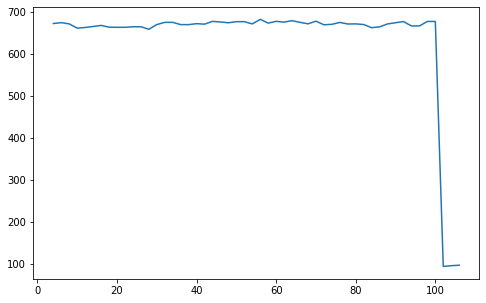

In [ ]:
pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(8,5))

Um dos grandes motivos para isso acontecer é por que **há muitas features para poucas linhas**.

**Isso pode ser corrigido com regularização**.

## Ridge Regression

**Obs**:
+ `Ridge(alpha=0.1, normalize=True)`
  - Quando menor o alpha, menor é a regularização


best k =  16 | mae =  81.84566514210034
['START YEAR', 'COMPLETION YEAR', 'V-1', 'V-7', 'V-8', 'V-14', 'V-20', 'V-14.1', 'V-20.1', 'V-14.2', 'V-20.2', 'V-14.3', 'V-17.3', 'V-20.3', 'V-17.4', 'V-20.4']


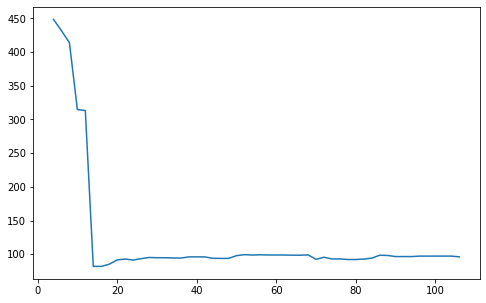

In [ ]:
k_vs_score = []
bests_features = None
best_score = 99999

for k in range(2, Xtrain.shape[1], 2):
  selector_model = Ridge(alpha=0.1, normalize=True)
  selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
  selector.fit(Xtrain, ytrain)
  Xtrain2 = selector.transform(Xtrain)
  Xval2 = selector.transform(Xval)
  # print(Xtrain.shape, Xtrain2.shape)
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)
  p = mdl.predict(Xval2)
  score = mean_absolute_error(yval, p)
  # print("k = {} - MAE = {}".format(k, score))
  k_vs_score.append(score)
  if score < best_score:
    best_score = score
    bests_features = selector.get_support()

print("Ridge Regression")
print("best k = ", np.sum(bests_features), "| mae = ", best_score)
print(Xtrain.columns[bests_features].values.tolist())

pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(8,5))

Chegamos ao mesmo MAE ~= 100 quando k = 15; enquanto na Regressão Linear, só atingiamos isso com k = 100;

### Regularização Lasso

Os coeficientes das `features` que não são importantes ele joga pra zero, ou seja, ele naturalmente já faz uma `feature selection`.

Lasso Regression
best k =  6 | mae =  85.90433604742891
['COMPLETION QUARTER', 'V-1', 'V-7', 'V-8', 'V-17.3', 'V-20.4']


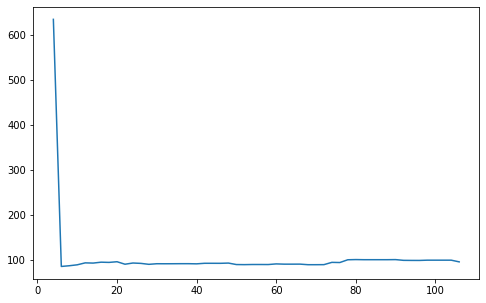

In [ ]:
k_vs_score = []
bests_features = None
best_score = 99999

for k in range(2, Xtrain.shape[1], 2):
  selector_model = Lasso(alpha=1.,normalize=True)
  selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
  selector.fit(Xtrain, ytrain)
  Xtrain2 = selector.transform(Xtrain)
  Xval2 = selector.transform(Xval)
  # print(Xtrain.shape, Xtrain2.shape)
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)
  p = mdl.predict(Xval2)
  score = mean_absolute_error(yval, p)
  # print("k = {} - MAE = {}".format(k, score))
  k_vs_score.append(score)
  if score < best_score:
    best_score = score
    bests_features = selector.get_support()

print("Lasso Regression")
print("best k = ", np.sum(bests_features), "| mae = ", best_score)
print(Xtrain.columns[bests_features].values.tolist())

pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(8,5))

Com 6 features ele já bateu o erro de 96

## Random Forest

Random Forest
best k =  98 | mae =  96.24822272023847
['START YEAR', 'COMPLETION YEAR', 'COMPLETION QUARTER', 'V-1', 'V-2', 'V-3', 'V-4', 'V-5', 'V-6', 'V-7', 'V-8', 'V-11', 'V-12', 'V-13', 'V-14', 'V-16', 'V-18', 'V-19', 'V-21', 'V-22', 'V-24', 'V-25', 'V-26', 'V-27', 'V-28', 'V-29', 'V-11.1', 'V-12.1', 'V-13.1', 'V-14.1', 'V-15.1', 'V-16.1', 'V-17.1', 'V-18.1', 'V-19.1', 'V-20.1', 'V-23.1', 'V-24.1', 'V-25.1', 'V-26.1', 'V-27.1', 'V-28.1', 'V-29.1', 'V-11.2', 'V-12.2', 'V-13.2', 'V-14.2', 'V-15.2', 'V-16.2', 'V-18.2', 'V-19.2', 'V-20.2', 'V-21.2', 'V-22.2', 'V-23.2', 'V-24.2', 'V-25.2', 'V-26.2', 'V-27.2', 'V-28.2', 'V-29.2', 'V-11.3', 'V-12.3', 'V-14.3', 'V-15.3', 'V-16.3', 'V-17.3', 'V-18.3', 'V-19.3', 'V-20.3', 'V-21.3', 'V-22.3', 'V-23.3', 'V-24.3', 'V-25.3', 'V-26.3', 'V-27.3', 'V-28.3', 'V-29.3', 'V-11.4', 'V-12.4', 'V-13.4', 'V-14.4', 'V-15.4', 'V-16.4', 'V-17.4', 'V-18.4', 'V-19.4', 'V-20.4', 'V-21.4', 'V-22.4', 'V-23.4', 'V-24.4', 'V-25.4', 'V-26.4', 'V-27.4', 'V-28.4', 'V-2

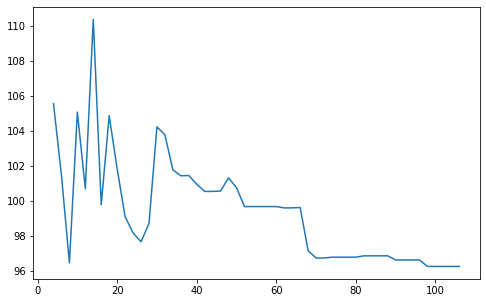

In [ ]:
k_vs_score = []
bests_features = None
best_score = 99999

for k in range(2, Xtrain.shape[1], 2):
  selector_model = RandomForestRegressor(random_state=1, n_jobs=-1)
  selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
  selector.fit(Xtrain, ytrain)
  Xtrain2 = selector.transform(Xtrain)
  Xval2 = selector.transform(Xval)
  # print(Xtrain.shape, Xtrain2.shape)
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)
  p = mdl.predict(Xval2)
  score = mean_absolute_error(yval, p)
  # print("k = {} - MAE = {}".format(k, score))
  k_vs_score.append(score)
  if score < best_score:
    best_score = score
    bests_features = selector.get_support()

print("Random Forest")
print("best k = ", np.sum(bests_features), "| mae = ", best_score)
print(Xtrain.columns[bests_features].values.tolist())

pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(8,5))

In [ ]:


k_vs_score = []

accumulate = 

for k in range(2, Xtrain.shape[1], 2):
  #selector_model = LinearRegression(normalize=True)
  #selector_model = Ridge(alpha=0.1, normalize=True)
  selector_model = Lasso(alpha=1.,normalize=True)
  #selector_model = RandomForestRegressor(random_state=1, n_jobs=-1)
  selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)

  selector.fit(Xtrain, ytrain)

  #Xtrain2 = np.zeros((Xtrain.shape[0], 7))
  Xtrain2 = selector.transform(Xtrain)
  #Xtrain2[:, -1] = Xtrain['START YEAR'].values

  #Xval2 = np.zeros((Xval.shape[0], 7))
  Xval2 = selector.transform(Xval)
  #Xval2[:, -1] = Xval['START YEAR'].values

  print(Xtrain.shape, Xtrain2.shape)

  #Xtrain.columns[selector.get_support()]

  #mdl = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)

  p = mdl.predict(Xval2)

  score = mean_absolute_error(yval, p)
  print("k = {} - MAE = {}".format(k, score))


  mask = selector.get_support()
  #print(Xtrain.columns[mask])

  k_vs_score.append(score)
  #break

# LinearRegression: k = 100, mae = 100
# Ridge : k =14 , mae = 100.5
# Lasso k = 6, mae = 96.07 - ['COMPLETION QUARTER', 'V-1', 'V-7', 'V-8', 'V-17.3', 'V-20.4']
# k = 4, mae 94.78
# rf - k=8 - Index(['V-1', 'V-5', 'V-7', 'V-8', 'V-11', 'V-14', 'V-14.1', 'V-11.2']
#

(186, 107) (186, 2)
k = 2 - MAE = 806.2421225270917
(186, 107) (186, 4)
k = 4 - MAE = 634.6845313451623
(186, 107) (186, 6)
k = 6 - MAE = 85.90433604742891
(186, 107) (186, 8)
k = 8 - MAE = 87.46077580605784
(186, 107) (186, 10)
k = 10 - MAE = 89.54654734621766
(186, 107) (186, 12)
k = 12 - MAE = 93.85027821858723
(186, 107) (186, 14)
k = 14 - MAE = 93.37699545583418
(186, 107) (186, 16)
k = 16 - MAE = 95.3654069797967
(186, 107) (186, 18)
k = 18 - MAE = 94.89478999312206
(186, 107) (186, 20)
k = 20 - MAE = 96.3717780164493
(186, 107) (186, 22)
k = 22 - MAE = 90.85807792089318
(186, 107) (186, 24)
k = 24 - MAE = 93.5140742230159
(186, 107) (186, 26)
k = 26 - MAE = 92.6986841181273
(186, 107) (186, 28)
k = 28 - MAE = 90.60947085965064
(186, 107) (186, 30)
k = 30 - MAE = 91.92900233114919
(186, 107) (186, 32)
k = 32 - MAE = 91.86852371051748
(186, 107) (186, 34)
k = 34 - MAE = 91.91730679747879
(186, 107) (186, 36)
k = 36 - MAE = 92.02566265803512
(186, 107) (186, 38)
k = 38 - MAE = 92.0

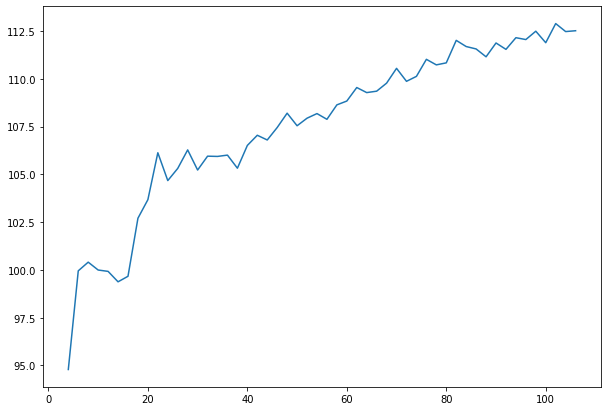

In [ ]:
pd.Series(k_vs_score[1:],index=range(4,X.shape[1],2)).plot(figsize=(10,7))

## Busca de `Features` por Monte-Carlo (Testando features aleartórias)

Vamos selecionar de 2 à 20 feautes aleartórias e vê quais que atingiram um MAE < 86

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


fs = []
for seed in range(1000):

  np.random.seed(seed)
  k = np.random.randint(2, 20, 1)[0]
  selected = np.random.choice(Xtrain.columns, k, replace=False)
  #print(selected)
  
  Xtrain2 = Xtrain[selected]
  Xval2 = Xval[selected]
  
  mdl = XGBRegressor(objective="reg:squarederror", seed=0)
  mdl.fit(Xtrain2, ytrain)

  p = mdl.predict(Xval2)

  score = mean_absolute_error(yval, p)
  if score < 86:
    print("seed = {} - k = {} - MAE = {}".format(seed, k, score))
    fs.append(p)


# k = 6, MAE = 85.904336
#seed = 54 - MAE = 78.62763148482128

seed = 222 - k = 8 - MAE = 79.29005563387307
seed = 298 - k = 14 - MAE = 84.73681025351247
seed = 558 - k = 11 - MAE = 83.52879317088794
seed = 623 - k = 16 - MAE = 78.78835075132308
